# Our Database

In [42]:
from sqlalchemy import create_engine, inspect, text

# Connect to database
engine = create_engine("sqlite:///movi.db", connect_args={"check_same_thread": False})

# Create inspector to get table names
inspector = inspect(engine)
tables = inspector.get_table_names()

print("📋 Tables in Database:")
for table in tables:
    print(f"\n--- {table} ---")
    with engine.connect() as conn:
        result = conn.execute(text(f"SELECT * FROM {table}"))
        rows = result.fetchall()
        for row in rows:
            print(dict(row._mapping))


📋 Tables in Database:

--- daily_trips ---
{'trip_id': 1, 'route_id': 1, 'display_name': 'Trip-01', 'booking_status_percentage': 0, 'live_status': 'IN'}
{'trip_id': 2, 'route_id': 2, 'display_name': 'Trip-02', 'booking_status_percentage': 50, 'live_status': 'Completed'}
{'trip_id': 3, 'route_id': 3, 'display_name': 'Trip-03', 'booking_status_percentage': 50, 'live_status': 'Not Started'}
{'trip_id': 4, 'route_id': 4, 'display_name': 'Trip-04', 'booking_status_percentage': 75, 'live_status': 'IN'}
{'trip_id': 5, 'route_id': 5, 'display_name': 'Trip-05', 'booking_status_percentage': 100, 'live_status': 'Not Started'}
{'trip_id': 6, 'route_id': 6, 'display_name': 'Trip-06', 'booking_status_percentage': 100, 'live_status': 'Completed'}
{'trip_id': 7, 'route_id': 7, 'display_name': 'Trip-07', 'booking_status_percentage': 0, 'live_status': 'Not Started'}
{'trip_id': 8, 'route_id': 8, 'display_name': 'Trip-08', 'booking_status_percentage': 10, 'live_status': 'Not Started'}
{'trip_id': 9, 'rou

# Basic Graph Agent

In [ ]:
from typing import TypedDict, Sequence, Optional, Annotated
from langgraph.graph import StateGraph, END
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langchain_openai import AzureChatOpenAI
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langchain.tools import tool
import json
from dotenv import load_dotenv
import os

load_dotenv()


# ============================================================
# 1) LLM Setup
# ============================================================
llm = AzureChatOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    azure_deployment=os.getenv("AZURE_OPENAI_DEPLOYMENT"),
    api_version="2025-01-01-preview",
    api_key=os.getenv("AZURE_OPENAI_API_KEY")
)


# ============================================================
# 2) Database Setup
# ============================================================
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from models import Stop, Path, Route, Vehicle, Driver, DailyTrip, Deployment

engine = create_engine("sqlite:///movi.db", connect_args={"check_same_thread": False})
SessionLocal = sessionmaker(bind=engine)

# ============================================================
# 3) Agent State
# ============================================================
class MoviState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    action_type: Optional[str]
    consequence: Optional[str]
    needs_confirmation: Optional[bool]
    pending_data: Optional[dict]

# ============================================================
# Helper: Load stop IDs from DB string
# ============================================================
def parse_stop_ids(raw):
    try:
        return json.loads(raw) if raw else []
    except:
        return []

# ============================================================
# 4) TOOLS
# ============================================================

# ---------------------------
# Dynamic Reads
# ---------------------------
@tool
def unassigned_vehicle_count() -> str:
    """Count all vehicles that are not assigned to any trip."""
    session = SessionLocal()
    assigned = {d.vehicle_id for d in session.query(Deployment).all()}
    total = session.query(Vehicle).count()
    session.close()
    return f"There are {total - len(assigned)} vehicles not assigned to any trip."


@tool
def trip_status(trip_name: str) -> str:
    """Return the dynamic status of a trip."""
    session = SessionLocal()
    trip = session.query(DailyTrip).filter(DailyTrip.display_name.ilike(f"%{trip_name}%")).first()
    if not trip:
        return f"Trip '{trip_name}' not found."
    session.close()
    return f"The status of '{trip.display_name}' is {trip.live_status} with {trip.booking_status_percentage}% bookings."

# ---------------------------
# Static Reads
# ---------------------------
@tool
def list_stops(path_name: str) -> str:
    """List all stops for a path."""
    session = SessionLocal()
    path = session.query(Path).filter(Path.path_name.ilike(f"%{path_name}%")).first()

    if not path:
        return f"No path found with name {path_name}."

    stop_ids = parse_stop_ids(path.ordered_list_of_stop_ids)
    if not stop_ids:
        return f"Path '{path_name}' has no stops."

    stops = session.query(Stop).filter(Stop.stop_id.in_(stop_ids)).all()
    session.close()

    names = [s.name for s in stops]
    return f"Stops in '{path_name}': " + ", ".join(names)


@tool
def list_routes(path_name: str) -> str:
    """List all routes that use a static path."""
    session = SessionLocal()
    path = session.query(Path).filter(Path.path_name.ilike(f"%{path_name}%")).first()
    if not path:
        return f"No path found with name {path_name}."

    routes = session.query(Route).filter(Route.path_id == path.path_id).all()
    session.close()

    return "The routes that use \"" + path_name + "\" are:\n\n- " + "\n- ".join([r.route_display_name for r in routes])

# ---------------------------
# CREATE tools
# ---------------------------
@tool
def create_stop(stop_name: str) -> str:
    """Create a new stop."""
    session = SessionLocal()
    new = Stop(name=stop_name)
    session.add(new)
    session.commit()
    session.close()
    return f"The new stop named '{stop_name}' has been successfully created."


@tool
def create_path(path_name: str, stop_list: list) -> str:
    """Create a new path using a list of stop names."""
    session = SessionLocal()
    stops = session.query(Stop).filter(Stop.name.in_(stop_list)).all()

    if len(stops) != len(stop_list):
        found = [s.name for s in stops]
        missing = [x for x in stop_list if x not in found]
        return f"Cannot create path. Missing stops: {missing}"

    stop_ids = [s.stop_id for s in stops]

    new = Path(
        path_name=path_name,
        ordered_list_of_stop_ids=json.dumps(stop_ids)  # FIXED
    )

    session.add(new)
    session.commit()
    session.close()
    return f"Path '{path_name}' has been created with stops: {', '.join(stop_list)}."


@tool
def assign_vehicle_driver(vehicle_plate: str, driver_name: str, trip_name: str) -> str:
    """Assign a vehicle and driver to a trip."""
    session = SessionLocal()

    vehicle = session.query(Vehicle).filter(Vehicle.license_plate == vehicle_plate).first()
    driver = session.query(Driver).filter(Driver.name == driver_name).first()
    trip = session.query(DailyTrip).filter(DailyTrip.display_name.ilike(f"%{trip_name}%")).first()

    if not vehicle:
        return f"Vehicle '{vehicle_plate}' not found."
    if not driver:
        return f"Driver '{driver_name}' not found."
    if not trip:
        return f"Trip '{trip_name}' not found."

    deployment = Deployment(
        trip_id=trip.trip_id,
        vehicle_id=vehicle.vehicle_id,
        driver_id=driver.driver_id,
    )
    session.add(deployment)
    session.commit()
    session.close()

    return f"The vehicle '{vehicle_plate}' and driver '{driver_name}' have been successfully assigned to '{trip_name}'."

# ---------------------------
# DELETE tools
# ---------------------------
@tool
def delete_vehicle_from_trip(trip_name: str) -> str:
    """Remove vehicle assignment from a trip."""
    session = SessionLocal()
    trip = session.query(DailyTrip).filter(DailyTrip.display_name.ilike(f"%{trip_name}%")).first()
    if not trip:
        return f"Trip '{trip_name}' not found."

    dep = session.query(Deployment).filter(Deployment.trip_id == trip.trip_id).first()
    if not dep:
        return f"No vehicle is assigned to '{trip_name}'."

    session.delete(dep)
    session.commit()
    session.close()
    return f"The vehicle has been successfully removed from '{trip_name}'."


# ---------------------------
# EXTRA tools
# ---------------------------
@tool
def toggle_route_status(route_name: str) -> str:
    """Activate or deactivate a route."""
    session = SessionLocal()
    route = session.query(Route).filter(Route.route_display_name.ilike(f"%{route_name}%")).first()
    if not route:
        return f"Route '{route_name}' not found."

    route.status = "active" if route.status == "deactivated" else "deactivated"
    session.commit()
    session.close()
    return f"Route '{route_name}' toggled to {route.status}."


@tool
def trip_progress(trip_name: str) -> str:
    """Return trip progress summary."""
    session = SessionLocal()
    trip = session.query(DailyTrip).filter(DailyTrip.display_name.ilike(f"%{trip_name}%")).first()
    if not trip:
        return f"Trip '{trip_name}' not found."
    return f"{trip.display_name} is currently '{trip.live_status}'."

# ============================================================
# TOOL LIST
# ============================================================
tools = [
    unassigned_vehicle_count,
    trip_status,
    list_stops,
    list_routes,
    create_stop,
    create_path,
    assign_vehicle_driver,
    delete_vehicle_from_trip,
    toggle_route_status,
    trip_progress,
]

llm_bound = llm.bind_tools(tools)

# ============================================================
# Agent Node
# ============================================================
def agent_node(state: MoviState) -> MoviState:
    system = SystemMessage(content="You are Movi, a transport operations assistant.")
    response = llm_bound.invoke([system] + state["messages"])
    return {"messages": [response]}

# ============================================================
# Routing Logic
# ============================================================
def should_continue(state: MoviState):
    last = state["messages"][-1]
    return "continue" if last.tool_calls else "end"

# ============================================================
# Graph Build
# ============================================================
graph = StateGraph(MoviState)

graph.add_node("agent", agent_node)

# Tool node

tool_node = ToolNode(tools=tools)

graph.add_node("tools", tool_node)

graph.set_entry_point("agent")

graph.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "end": END
    }
)

graph.add_edge("tools", "agent")

app = graph.compile()

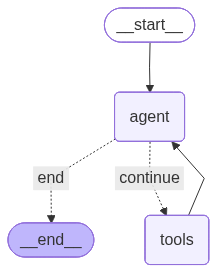

In [122]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [120]:
# movilab_runner_safe.py
from langchain_core.messages import HumanMessage


def ask_movi_safe(query: str):
    print("\n============================")
    print(f"USER QUESTION: {query}")
    print("============================")

    try:
        # Try sending the query to the agent
        result = app.invoke({"messages": [HumanMessage(content=query)]})

        # Extract last message
        final_msg = result["messages"][-1]

        # Extract content (some messages have content, some are tool messages)
        response = getattr(final_msg, "content", str(final_msg))

        print("MOVI RESPONSE:")
        print(response)

    except Exception as e:
        # If any error happens, DO NOT stop execution
        print("❌ ERROR OCCURRED FOR THIS QUESTION:")
        print(str(e))

    print("\n")  # spacing


if __name__ == "__main__":

    # ---- Questions adapted for your DB ----
    questions = [
        "Hi",
        "How many vehicles are not assigned?",
        "What’s the status of 'Trip-04'?",
        "List all stops for 'Path-2'.",
        "Show me all routes that use 'Path-1'.",
        "Assign vehicle 'KA-05-1004' and driver 'Amit' to the 'Trip-03' trip.",
        "Remove the vehicle from 'Trip-01'.",
        "Create a new stop called 'Odeon Circle'.",
        "Create a new path called 'Tech-Loop' using stops [Gavipuram, temple, Peenya].",

        # Add intentionally wrong questions for testing error-handling
        "Show me stops for 'Unknown-Path'.",
        "Assign vehicle 'XYZ' to 'Trip-99'."
    ]

    for q in questions:
        ask_movi_safe(q)



USER QUESTION: Hi


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
Hello! How can I assist you today?



USER QUESTION: How many vehicles are not assigned?


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
There are currently 3 vehicles that are not assigned to any trip.



USER QUESTION: What’s the status of 'Trip-04'?


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
The status of 'Trip-04' is active ("IN") with 75% of the bookings filled.



USER QUESTION: List all stops for 'Path-2'.


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
There are no stops listed for "Path-2".



USER QUESTION: Show me all routes that use 'Path-1'.


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
The routes that use "Path-1" are:

- **Path-1 - 20:00**
- **Path-1 - 10:00**



USER QUESTION: Assign vehicle 'KA-05-1004' and driver 'Amit' to the 'Trip-03' trip.


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
The vehicle 'KA-05-1004' and driver 'Amit' have been successfully assigned to the trip 'Trip-03'.



USER QUESTION: Remove the vehicle from 'Trip-01'.


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
No vehicle is currently assigned to "Trip-01", so there is nothing to remove.



USER QUESTION: Create a new stop called 'Odeon Circle'.


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
The new stop named 'Odeon Circle' has been successfully created.



USER QUESTION: Create a new path called 'Tech-Loop' using stops [Gavipuram, temple, Peenya].


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
Despite having all the required stops created, the "Tech-Loop" path cannot be set up. This seems to be an underlying issue beyond the stops themselves. Can I assist you with anything else related to transport operations?



USER QUESTION: Show me stops for 'Unknown-Path'.


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
It seems there's no path found with the name "Unknown-Path". Please verify the name or let me know if you'd like to create a new path.



USER QUESTION: Assign vehicle 'XYZ' to 'Trip-99'.


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
Could you provide the driver's name to assign along with the vehicle 'XYZ' to 'Trip-99'?




# Advance Graph Agent

In [ ]:
from typing import TypedDict, Sequence, Optional, Annotated, Dict, Any
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages

from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    SystemMessage,
    AIMessage
)

from langchain.tools import tool
from langchain_openai import AzureChatOpenAI

import json
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
from models import Stop, Path, Route, Vehicle, Driver, DailyTrip, Deployment



# ============================================================
# 0) LLM CONFIG
# ============================================================
llm = AzureChatOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    azure_deployment=os.getenv("AZURE_OPENAI_DEPLOYMENT"),
    api_version="2025-01-01-preview",
    api_key=os.getenv("AZURE_OPENAI_API_KEY")
)




# ============================================================
# 1) DATABASE SETUP
# ============================================================
engine = create_engine("sqlite:///movi.db", connect_args={"check_same_thread": False})
SessionLocal = sessionmaker(bind=engine)



# ============================================================
# 2) STATE
# ============================================================
class MoviState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

    # for DB modifying tools
    pending_tool_needs_confirm: Optional[dict]    # {"name":..., "args":...}

    # for SQL path
    pending_sql: Optional[str]
    pending_sql_type: Optional[str]              # read | write
    pending_sql_result: Optional[Any]

    final_message: Optional[str]

    # Optional short memory (only last user question)
    user_question: Optional[str]



# ============================================================
# 3) HELPERS
# ============================================================
def parse_stop_ids(raw):
    try:
        return json.loads(raw) if raw else []
    except:
        return []

def pick_original_user_message(messages: Sequence[BaseMessage]):
    """Return earliest HumanMessage that is NOT a system/prompt injection."""
    if not messages:
        return None

    blacklist = (
        "confirm?", "generated sql", "this will modify", "sql result",
        "tool", "preview", "cancel"
    )

    humans = [m for m in messages if isinstance(m, HumanMessage)]
    if not humans:
        return None

    for hm in humans:
        txt = hm.content.strip().lower()
        if not any(txt.startswith(b) for b in blacklist):
            return hm

    return humans[0]



# ============================================================
# 4) TOOLS
# ============================================================
@tool
def unassigned_vehicle_count() -> str:
    """Count vehicles not assigned to any trip."""
    session = SessionLocal()
    assigned = {d.vehicle_id for d in session.query(Deployment).all()}
    total = session.query(Vehicle).count()
    session.close()
    return f"There are {total - len(assigned)} vehicles not assigned to any trip."


@tool
def trip_status(trip_name: str) -> str:
    """Return status and booking percentage for a trip."""
    session = SessionLocal()
    trip = session.query(DailyTrip).filter(DailyTrip.display_name.ilike(f"%{trip_name}%")).first()
    session.close()
    if not trip:
        return f"Trip '{trip_name}' not found."
    return f"The status of '{trip.display_name}' is {trip.live_status} with {trip.booking_status_percentage}% bookings."


@tool
def list_stops(path_name: str) -> str:
    """List stops for a path."""
    session = SessionLocal()
    path = session.query(Path).filter(Path.path_name.ilike(f"%{path_name}%")).first()
    if not path:
        session.close()
        return f"No path found with name '{path_name}'."
    stop_ids = parse_stop_ids(path.ordered_list_of_stop_ids)
    if not stop_ids:
        session.close()
        return f"Path '{path_name}' has no stops."
    stops = session.query(Stop).filter(Stop.stop_id.in_(stop_ids)).all()
    session.close()
    return "Stops: " + ", ".join([s.name for s in stops])


@tool
def list_routes(path_name: str) -> str:
    """List routes using a path."""
    session = SessionLocal()
    path = session.query(Path).filter(Path.path_name.ilike(f"%{path_name}%")).first()
    if not path:
        session.close()
        return f"No path found with name '{path_name}'."
    routes = session.query(Route).filter(Route.path_id == path.path_id).all()
    session.close()
    return "The routes using this path:\n- " + "\n- ".join([r.route_display_name for r in routes])


@tool
def create_stop(stop_name: str) -> str:
    """Create a new stop."""
    session = SessionLocal()
    new = Stop(name=stop_name)
    session.add(new)
    session.commit()
    session.close()
    return f"Stop '{stop_name}' created."


@tool
def create_path(path_name: str, stop_list: list) -> str:
    """Create a new path using stops."""
    session = SessionLocal()
    stops = session.query(Stop).filter(Stop.name.in_(stop_list)).all()
    if len(stops) != len(stop_list):
        found = {s.name for s in stops}
        missing = [x for x in stop_list if x not in found]
        session.close()
        return f"Cannot create path. Missing: {missing}"

    stop_ids = [s.stop_id for s in stops]
    new = Path(path_name=path_name, ordered_list_of_stop_ids=json.dumps(stop_ids))
    session.add(new)
    session.commit()
    session.close()
    return f"Path '{path_name}' created successfully."


@tool
def assign_vehicle_driver(vehicle_plate: str, driver_name: str, trip_name: str) -> str:
    """Assign a vehicle and driver to a trip."""
    session = SessionLocal()
    vehicle = session.query(Vehicle).filter(Vehicle.license_plate == vehicle_plate).first()
    driver = session.query(Driver).filter(Driver.name == driver_name).first()
    trip = session.query(DailyTrip).filter(DailyTrip.display_name.ilike(f"%{trip_name}%")).first()

    if not vehicle:
        session.close()
        return f"Vehicle '{vehicle_plate}' not found."
    if not driver:
        session.close()
        return f"Driver '{driver_name}' not found."
    if not trip:
        session.close()
        return f"Trip '{trip_name}' not found."

    session.add(Deployment(trip_id=trip.trip_id, vehicle_id=vehicle.vehicle_id, driver_id=driver.driver_id))
    session.commit()
    session.close()
    return f"Assigned vehicle '{vehicle_plate}' and driver '{driver_name}' to '{trip_name}'."


@tool
def delete_vehicle_from_trip(trip_name: str) -> str:
    """Remove vehicle assignment from a trip."""
    session = SessionLocal()
    trip = session.query(DailyTrip).filter(DailyTrip.display_name.ilike(f"%{trip_name}%")).first()
    if not trip:
        session.close()
        return f"Trip '{trip_name}' not found."
    dep = session.query(Deployment).filter(Deployment.trip_id == trip.trip_id).first()
    if not dep:
        session.close()
        return f"No vehicle assigned to '{trip_name}'."
    session.delete(dep)
    session.commit()
    session.close()
    return f"Vehicle removed from '{trip_name}'."


@tool
def toggle_route_status(route_name: str) -> str:
    """Toggle a route's status."""
    session = SessionLocal()
    route = session.query(Route).filter(Route.route_display_name.ilike(f"%{route_name}%")).first()
    if not route:
        session.close()
        return f"Route '{route_name}' not found."
    route.status = "active" if route.status == "deactivated" else "deactivated"
    session.commit()
    session.close()
    return f"Route '{route_name}' toggled to {route.status}."



TOOLS = {
    "unassigned_vehicle_count": unassigned_vehicle_count,
    "trip_status": trip_status,
    "list_stops": list_stops,
    "list_routes": list_routes,
    "create_stop": create_stop,
    "create_path": create_path,
    "assign_vehicle_driver": assign_vehicle_driver,
    "delete_vehicle_from_trip": delete_vehicle_from_trip,
    "toggle_route_status": toggle_route_status,
}

DB_MODIFYING_TOOLS = {
    "create_stop",
    "create_path",
    "assign_vehicle_driver",
    "delete_vehicle_from_trip",
    "toggle_route_status",
}



# ============================================================
# Bind tools to LLM
# ============================================================
llm_bound = llm.bind_tools(list(TOOLS.values()))



# ============================================================
# 5) GRAPH NODES
# ============================================================

graph = StateGraph(MoviState)



# -------------------------------------------------------------------
# AGENT NODE  (detect tools, or fallback to SQL)
# -------------------------------------------------------------------
def agent_node(state: MoviState) -> MoviState:
    system = SystemMessage(content=
        "You are Movi. If a tool can answer the user's question, you MUST call the tool.\n"
        "Otherwise, do NOT call any tool, and the SQL generator will handle the question.\n"
        "Output exactly one tool_call if needed."
    )

    # store last user message in 2-turn memory
    msgs = state.get("messages", [])
    humans = [m for m in msgs if isinstance(m, HumanMessage)]
    if humans:
        state["user_question"] = humans[-1].content

    user_q = state.get("user_question") or "Hi"

    response = llm_bound.invoke([system, HumanMessage(content=user_q)])

    # TOOL DETECTED
    if hasattr(response, "tool_calls") and response.tool_calls:
        call = response.tool_calls[0]
        name = call["name"]

        if name in DB_MODIFYING_TOOLS:
            # Ask confirmation first
            return {
                "messages": [
                    AIMessage(content=f"This operation will modify the DB.\n"
                                      f"Tool '{name}' with args {call['args']}. Confirm? (yes/no)")
                ],
                "pending_tool_needs_confirm": call
            }

        # Non-modifying tool → direct tool execution
        return {"messages": [response]}

    # NO TOOL → SQL path
    return {"messages": [response]}



graph.add_node("agent", agent_node)



# -------------------------------------------------------------------
# CONFIRM TOOL NODE
# -------------------------------------------------------------------
def confirm_tool_node(state: MoviState) -> MoviState:
    pending = state.get("pending_tool_needs_confirm")
    if not pending:
        return {
            "messages": [HumanMessage(content="No pending tool to confirm.")],
            "pending_tool_needs_confirm": None
        }

    last = state["messages"][-1].content.strip().lower()

    # User confirmed
    if last in {"yes", "y", "confirm", "ok", "sure"}:
        user_q = state.get("user_question") or "Please run the tool again."

        system = SystemMessage(content=
            "Reproduce ONLY the tool_call for this user request.\n"
            "No text. No explanation. No markdown.\n"
            "Output a structured tool_call."
        )

        ai = llm_bound.invoke([system, HumanMessage(content=user_q)])

        return {
            "messages": [ai],   # MUST be AIMessage with tool_call → ToolNode runs it
            "pending_tool_needs_confirm": None
        }

    # user cancelled
    if last in {"no", "n", "cancel"}:
        return {
            "messages": [HumanMessage(content="Tool execution cancelled.")],
            "pending_tool_needs_confirm": None,
            "final_message": "Tool execution cancelled."
        }

    # still waiting for confirmation
    name = pending["name"]
    args = pending["args"]
    return {
        "messages": [
            AIMessage(content=f"Tool '{name}' will modify DB.\nArgs: {args}\nConfirm? (yes/no)")
        ],
        "pending_tool_needs_confirm": pending
    }


graph.add_node("confirm_tool", confirm_tool_node)



# -------------------------------------------------------------------
# TOOL EXECUTION (ToolNode)
# -------------------------------------------------------------------
tool_node = ToolNode(tools=list(TOOLS.values()))
graph.add_node("tools", tool_node)



# After tool execution
def post_tool(state: MoviState) -> MoviState:
    last = state["messages"][-1].content
    return {
        "messages": [HumanMessage(content=last)],
        "final_message": last
    }
graph.add_node("post_tool", post_tool)



# -------------------------------------------------------------------
# SQL GENERATOR
# -------------------------------------------------------------------
def sql_generator_node(state: MoviState) -> MoviState:
    user_q = state.get("user_question") or "Hi"

    system = SystemMessage(content=
        "You are an expert SQLite generator. Respond with ONLY one SQL query."
    )

    resp = llm.invoke([system, HumanMessage(content=user_q)])
    sql = resp.content.strip()

    sql_type = "write" if any(k in sql.lower() for k in ("insert", "update", "delete")) else "read"

    return {
        "messages": [AIMessage(content=f"Generated SQL: {sql}")],
        "pending_sql": sql,
        "pending_sql_type": sql_type,
    }

graph.add_node("sql_gen", sql_generator_node)



# SQL CHECK
def sql_check_node(state: MoviState) -> MoviState:
    sql = state["pending_sql"]
    if state["pending_sql_type"] == "read":
        return {"messages": [AIMessage(content="SQL is read-only. Executing…")]}
    return {"messages": [AIMessage(content="SQL will modify DB.\nConfirm? (yes/no)")]}

graph.add_node("sql_check", sql_check_node)



# SQL CONFIRM
def confirm_sql_node(state: MoviState) -> MoviState:
    last = state["messages"][-1].content.strip().lower()

    if last in {"yes", "y", "ok", "confirm"}:
        return {"messages": [AIMessage(content="Confirmed. Running SQL now.")]}
    if last in {"no", "n", "cancel"}:
        return {
            "messages": [HumanMessage(content="SQL cancelled.")],
            "pending_sql": None,
            "final_message": "SQL cancelled."
        }

    sql_preview = state["pending_sql"][:200]
    return {
        "messages": [
            AIMessage(content=f"This SQL will modify DB:\n{sql_preview}\nConfirm? (yes/no)")
        ]
    }

graph.add_node("confirm_sql", confirm_sql_node)



# SQL EXECUTE
def sql_exec_node(state: MoviState) -> MoviState:
    sql = state["pending_sql"]
    session = SessionLocal()

    try:
        if state["pending_sql_type"] == "read":
            rows = session.execute(text(sql)).fetchall()
            result = [dict(r._mapping) for r in rows]
        else:
            session.execute(text(sql))
            session.commit()
            result = {"status": "success"}

    except Exception as e:
        result = {"error": str(e)}

    finally:
        session.close()

    return {
        "messages": [AIMessage(content=f"SQL result: {json.dumps(result)}")],
        "pending_sql_result": result
    }

graph.add_node("sql_exec", sql_exec_node)



# SQL INTERPRET
def sql_interpret_node(state: MoviState) -> MoviState:
    user_q = state.get("user_question") or ""
    result = state.get("pending_sql_result", {})

    system = SystemMessage(content="Convert the SQL result to a natural language answer.")
    resp = llm.invoke([
        system,
        HumanMessage(content=f"User question: {user_q}"),
        HumanMessage(content=f"SQL result: {json.dumps(result)}")
    ])

    return {
        "messages": [resp],
        "final_message": resp.content
    }

graph.add_node("sql_interpret", sql_interpret_node)



# END NODES
def end_success(state: MoviState):
    m = state["final_message"] or "Done."
    return {"messages": [HumanMessage(content=m)], "final_message": m}

def end_cancel(state: MoviState):
    m = state["final_message"] or "Cancelled."
    return {"messages": [HumanMessage(content=m)], "final_message": m}

graph.add_node("end_success", end_success)
graph.add_node("end_cancel", end_cancel)



# ============================================================
# ROUTING (acyclic)
# ============================================================

graph.set_entry_point("agent")

def agent_router(state):
    if state.get("pending_tool_needs_confirm"):
        return "confirm_tool"

    # if last message is AIMessage with tool_call → go to ToolNode
    last = state["messages"][-1]
    if hasattr(last, "tool_calls") and last.tool_calls:
        return "tools"

    return "sql_gen"

graph.add_conditional_edges("agent", agent_router, {
    "confirm_tool": "confirm_tool",
    "tools": "tools",
    "sql_gen": "sql_gen"
})


# confirm_tool → tools or end_cancel
def confirm_tool_router(state):
    last = state["messages"][-1]
    if isinstance(last, AIMessage) and hasattr(last, "tool_calls") and last.tool_calls:
        return "tools"
    if state["pending_tool_needs_confirm"] is None and state["final_message"]:
        return "end_cancel"
    return "tools"

graph.add_conditional_edges("confirm_tool", confirm_tool_router, {
    "tools": "tools",
    "end_cancel": "end_cancel"
})


# tools → post_tool → end_success
graph.add_edge("tools", "post_tool")
graph.add_edge("post_tool", "end_success")


# sql_gen → sql_check
graph.add_edge("sql_gen", "sql_check")


# sql_check → sql_exec (read) OR → confirm_sql (write)
def sql_check_router(state):
    return "sql_exec" if state["pending_sql_type"] == "read" else "confirm_sql"

graph.add_conditional_edges("sql_check", sql_check_router, {
    "sql_exec": "sql_exec",
    "confirm_sql": "confirm_sql"
})


# confirm_sql → sql_exec OR end_cancel
def confirm_sql_router(state):
    last = state["messages"][-1].content.strip().lower()
    if last in {"yes", "y", "ok", "confirm"}:
        return "sql_exec"
    if last in {"no", "n", "cancel"}:
        return "end_cancel"
    return "confirm_sql"

graph.add_conditional_edges("confirm_sql", confirm_sql_router, {
    "sql_exec": "sql_exec",
    "end_cancel": "end_cancel"
})


# sql_exec → sql_interpret → end_success
graph.add_edge("sql_exec", "sql_interpret")
graph.add_edge("sql_interpret", "end_success")


# END → END
graph.add_edge("end_success", END)
graph.add_edge("end_cancel", END)



# ============================================================
# COMPILE GRAPH
# ============================================================
app = graph.compile()


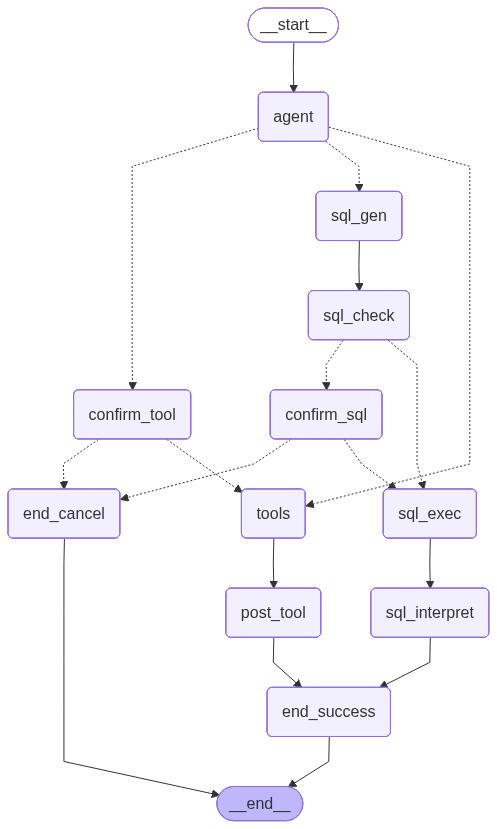

In [125]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [111]:
# movilab_runner_safe.py
from langchain_core.messages import HumanMessage

def ask_movi_safe(query: str):
    """Send a query to the MOVI agent and safely print the result."""
    print("\n============================")
    print(f"USER QUESTION: {query}")
    print("============================")

    try:
        # Send question to the graph app
        result = app.invoke({"messages": [HumanMessage(content=query)]})

        # Extract last message
        last_msg = result["messages"][-1]

        # Some messages have .content, some may be raw dicts
        response = getattr(last_msg, "content", str(last_msg))

        print("MOVI RESPONSE:")
        print(response)

    except Exception as e:
        print("❌ ERROR OCCURRED FOR THIS QUESTION:")
        print(str(e))

    print("\n")  # spacing


if __name__ == "__main__":
    print("🚀 MOVI Assistant Interactive Mode")
    print("Type your question and press Enter.")
    print("Type 'exit', 'quit', or 'q' to stop.")
    print("-" * 60)

    while True:
        user_input = input("\n👉 Your question: ").strip()

        if user_input.lower() in {"exit", "quit", "q"}:
            print("\n👋 Exiting MOVI Assistant. Goodbye!\n")
            break

        if not user_input:
            print("⚠️ Please enter a valid question.")
            continue

        ask_movi_safe(user_input)


🚀 MOVI Assistant Interactive Mode
Type your question and press Enter.
Type 'exit', 'quit', or 'q' to stop.
------------------------------------------------------------

USER QUESTION: Hi


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
The result indicates a response: "Hello, how can I assist you with SQLite today?"



USER QUESTION: HI


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
The response is: "Hello!"



USER QUESTION: What’s the status of 'Trip-04'?


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
The status of 'Trip-04' is IN with 75% bookings.



USER QUESTION: Remove the vehicle from 'Trip-01'.


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
Tool 'delete_vehicle_from_trip' will modify DB.
Args: {'trip_name': 'Trip-01'}
Confirm? (yes/no)



USER QUESTION: No


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
The result indicates: "Hello, how can I assist you?"



USER QUESTION: Remove the vehicle from 'Trip-01'.


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
Tool 'delete_vehicle_from_trip' will modify DB.
Args: {'trip_name': 'Trip-01'}
Confirm? (yes/no)



USER QUESTION: yes


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
The response is: "Hello, how can I assist you?"



USER QUESTION: stops for the vehicle from 'Trip-01'.


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
The status of 'Trip-01' is IN with 0% bookings.



USER QUESTION: show me all routes that use'Path-"


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
The routes using this path:
- Path-1 - 20:00
- Path-1 - 10:00



USER QUESTION: show me all routes that use'Path-1


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
The routes using this path:
- Path-1 - 20:00
- Path-1 - 10:00



USER QUESTION: show me all routes that use'Path-2


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
The routes using this path:
- Path-2 - 14:00
- Path-2 - 08:00



USER QUESTION: show me all routes that use'Path-3


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
The routes using this path:
- Path-3 - 18:00
- Path-3 - 20:00



USER QUESTION: show me all routes that use'Path-


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
The routes using this path:
- Path-1 - 20:00
- Path-1 - 10:00



USER QUESTION: Remove the vehicle from 'Trip-01'.


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
Tool 'delete_vehicle_from_trip' will modify DB.
Args: {'trip_name': 'Trip-01'}
Confirm? (yes/no)



USER QUESTION: yes


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
The result indicates the following message: "Hello! How can I assist you with your SQL queries today?"



USER QUESTION: What’s the status of 'Trip-01


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
The status of 'Trip-01' is IN with 0% bookings.



USER QUESTION: remove ttrip-01


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
Tool 'delete_vehicle_from_trip' will modify DB.
Args: {'trip_name': 'ttrip-01'}
Confirm? (yes/no)



USER QUESTION: yes


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
The response is: "Hello, how can I help you?"



USER QUESTION: What’s the status of 'Trip-01'


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
The status of 'Trip-01' is IN with 0% bookings.



USER QUESTION: cahne the bookings for trip-01 to 50%


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
The status of 'Trip-01' is IN with 0% bookings.



👋 Exiting MOVI Assistant. Goodbye!



In [126]:
# movilab_runner_safe.py
from langchain_core.messages import HumanMessage


def ask_movi_safe(query: str):
    print("\n============================")
    print(f"USER QUESTION: {query}")
    print("============================")

    try:
        # Try sending the query to the agent
        result = app.invoke({"messages": [HumanMessage(content=query)]})

        # Extract last message
        final_msg = result["messages"][-1]

        # Extract content (some messages have content, some are tool messages)
        response = getattr(final_msg, "content", str(final_msg))

        print("MOVI RESPONSE:")
        print(response)

    except Exception as e:
        # If any error happens, DO NOT stop execution
        print("❌ ERROR OCCURRED FOR THIS QUESTION:")
        print(str(e))

    print("\n")  # spacing


if __name__ == "__main__":

    # ---- Questions adapted for your DB ----
    questions = [
        "Hi",
        "How many vehicles are not assigned?",
        "What’s the status of 'Trip-04'?",
        "List all stops for 'Path-2'.",
        "Show me all routes that use 'Path-1'.",
        "Assign vehicle 'KA-05-1004' and driver 'Amit' to the 'Trip-03' trip.",
        "Remove the vehicle from 'Trip-01'.",
        "Create a new stop called 'Odeon Circle'.",
        "Create a new path called 'Tech-Loop' using stops [Gavipuram, temple, Peenya].",

        # Add intentionally wrong questions for testing error-handling
        "Show me stops for 'Unknown-Path'.",
        "Assign vehicle 'XYZ' to 'Trip-99'."
    ]

    for q in questions:
        ask_movi_safe(q)



USER QUESTION: Hi


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
The response is: "Hello, how can I help you?"



USER QUESTION: How many vehicles are not assigned?


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
There are 3 vehicles not assigned to any trip.



USER QUESTION: What’s the status of 'Trip-04'?


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
The status of 'Trip-04' is IN with 75% bookings.



USER QUESTION: List all stops for 'Path-2'.


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
Path 'Path-2' has no stops.



USER QUESTION: Show me all routes that use 'Path-1'.


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
The routes using this path:
- Path-1 - 20:00
- Path-1 - 10:00



USER QUESTION: Assign vehicle 'KA-05-1004' and driver 'Amit' to the 'Trip-03' trip.


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
Tool 'assign_vehicle_driver' will modify DB.
Args: {'vehicle_plate': 'KA-05-1004', 'driver_name': 'Amit', 'trip_name': 'Trip-03'}
Confirm? (yes/no)



USER QUESTION: Remove the vehicle from 'Trip-01'.


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
Tool 'delete_vehicle_from_trip' will modify DB.
Args: {'trip_name': 'Trip-01'}
Confirm? (yes/no)



USER QUESTION: Create a new stop called 'Odeon Circle'.


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
Tool 'create_stop' will modify DB.
Args: {'stop_name': 'Odeon Circle'}
Confirm? (yes/no)



USER QUESTION: Create a new path called 'Tech-Loop' using stops [Gavipuram, temple, Peenya].


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
Tool 'create_path' will modify DB.
Args: {'path_name': 'Tech-Loop', 'stop_list': ['Gavipuram', 'temple', 'Peenya']}
Confirm? (yes/no)



USER QUESTION: Show me stops for 'Unknown-Path'.


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
No path found with name 'Unknown-Path'.



USER QUESTION: Assign vehicle 'XYZ' to 'Trip-99'.


INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openai-for-bizapps.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


MOVI RESPONSE:
The result simply says: "Hello! How can I assist you with SQL today?"


